#### **Purpose:**
This cell imports the necessary libraries for model interpretation and defines the file paths for loading the trained models, scalers, and datasets saved from the previous notebook.

#### **Code Functionality:**
* Imports **pandas**, **joblib** (for loading models), **shap** (for interpretation), **xgboost**, **StandardScaler**, **matplotlib**, and **os**.
* Defines the directory paths for models, data, and visualizations to keep the workspace organized.

#### **Output Analysis:**
This cell prints a confirmation message that the notebook has started and produces no other output.

In [1]:
import pandas as pd
import joblib
import shap
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')

# --- Configuration ---
MODELS_DIR = 'E:/Project_3/Recession_Prediction_Network_Analysis/models/'
DATA_DIR = 'E:/Project_3/Recession_Prediction_Network_Analysis/data/'
VISUALIZATIONS_DIR = 'E:/Project_3/Recession_Prediction_Network_Analysis/visualizations/'

os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)

print("✅ Starting Phase 4: Model Interpretation with SHAP.")

e:\Project 1\main\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Starting Phase 4: Model Interpretation with SHAP.


#### **Purpose:**
This cell loads the key assets created in Notebook 03: the trained Enhanced XGBoost model, the fitted scaler, and the scaled training and validation datasets. These are required to explain the model's predictions.

#### **Code Functionality:**
* Defines the full file paths for the model (`.joblib`), scaler (`.joblib`), and scaled data (`.csv`) files.
* Uses `joblib.load()` to load the serialized model and scaler objects.
* Uses `pd.read_csv()` to load the scaled training and validation feature sets, ensuring the 'Date' column is correctly parsed as the index.
* A `try-except` block handles potential `FileNotFoundError` if the assets were not saved correctly in the previous notebook.

#### **Output Analysis:**
The output confirms that the model, scaler, and data have been loaded successfully, and it prints the shapes of the loaded DataFrames to verify their integrity.

In [2]:
# --- Step 4.1: Load Assets for Interpretation ---
print("Step 4.1: Load Assets for Interpretation")

# File Paths
MODEL_PATH = os.path.join(MODELS_DIR, 'enhanced_xgb_model.joblib')
SCALER_PATH = os.path.join(MODELS_DIR, 'scaler_enhanced.joblib')
X_TRAIN_SCALED_PATH = os.path.join(DATA_DIR, 'X_train_scaled_enhanced.csv')
X_VAL_SCALED_PATH = os.path.join(DATA_DIR, 'X_val_scaled_enhanced.csv')

try:
    model_xgb_enhanced = joblib.load(MODEL_PATH)
    scaler_enhanced = joblib.load(SCALER_PATH)
    
    # Use index_col=0 to specify that the first column is the index
    X_train_scaled_enhanced = pd.read_csv(X_TRAIN_SCALED_PATH, index_col=0, parse_dates=True)
    X_val_scaled_enhanced = pd.read_csv(X_VAL_SCALED_PATH, index_col=0, parse_dates=True)
      
    print("✅ Model, scaler, and data loaded successfully.")
    
except Exception as e:
    print(f"❌ Error loading files: {e}. Please ensure Notebook 03 was run and saved correctly.")

Step 4.1: Load Assets for Interpretation
✅ Model, scaler, and data loaded successfully.


#### **Purpose:**
This cell performs the initial SHAP analysis on the best-performing model (Enhanced XGBoost) to understand which features have the most predictive power globally.

#### **Code Functionality:**
* Initializes a `shap.TreeExplainer`, which is optimized for tree-based models like XGBoost.
* To manage memory usage, it takes a random sample of 100 data points from the validation set using `shap.sample`.
* Calculates the SHAP values for this sample.
* Generates and saves the SHAP summary plot, which ranks features by importance and shows the directionality of their impact.

#### **Output Analysis:**
The output confirms the calculation of SHAP values and displays the summary plot. This initial analysis reveals that the model's predictions are dominated by traditional economic indicators (e.g., `USALOLITONOSTSAM_mom_change`, `CPIAUCSL_yoy_change`, `T10Y3MM_roll12_mean`), with no network centrality features appearing in the top rankings. This provides the motivation for the experiment in the next cells.


Step 4.2: SHAP Analysis on Full Enhanced Model
✅ SHAP TreeExplainer created.
⏳ Calculating SHAP values on a sample of 100 data points...
✅ SHAP values calculated.

📊 Generating SHAP Summary Plot...


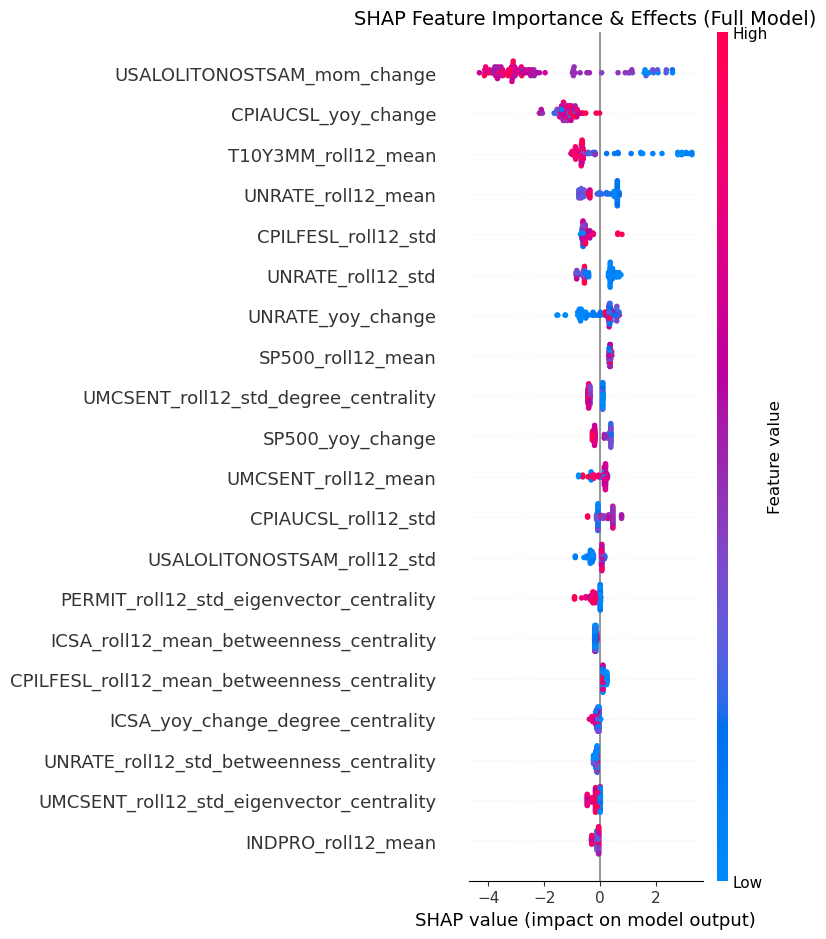

✅ SHAP summary plot saved to: E:/Project_3/Recession_Prediction_Network_Analysis/visualizations/shap_summary_plot_FULL.png


In [3]:
# --- Step 4.2: SHAP Analysis on Full Model ---
print("\nStep 4.2: SHAP Analysis on Full Enhanced Model")

# Use the optimized TreeExplainer for XGBoost
explainer = shap.TreeExplainer(model_xgb_enhanced)
print("✅ SHAP TreeExplainer created.")

# Use a sample of the validation data to prevent memory issues
X_val_sample = shap.sample(X_val_scaled_enhanced, 100) 

print(f"⏳ Calculating SHAP values on a sample of {len(X_val_sample)} data points...")
shap_values_sample = explainer(X_val_sample)
print("✅ SHAP values calculated.")

# Generate and Save the SHAP Plot
print("\n📊 Generating SHAP Summary Plot...")
plt.figure()
plt.title("SHAP Feature Importance & Effects (Full Model)", fontsize=14)
shap.summary_plot(shap_values_sample, X_val_sample, show=False)
plt.tight_layout()
summary_plot_path = os.path.join(VISUALIZATIONS_DIR, 'shap_summary_plot_FULL.png')
plt.savefig(summary_plot_path, dpi=300)
plt.show()
print(f"✅ SHAP summary plot saved to: {summary_plot_path}")

#### **Purpose:**
Based on the results of the first SHAP analysis, this cell sets up an experiment to test a new hypothesis: "If the model cannot rely on the most dominant traditional indicators, will the network features become more important?"

#### **Code Functionality:**
* Loads the complete augmented dataset (features and target) from before the train/test split.
* Defines a list, `features_to_drop`, containing the names of the top-performing traditional features identified in the previous cell.
* Creates a new DataFrame, `X_reduced`, by dropping these columns.
* Re-splits the `X_reduced` data and the `y_aligned` target into training and validation sets using the same date cutoffs as before.
* Initializes and fits a *new* `StandardScaler` (`scaler_reduced`) on the new, smaller training set.

#### **Output Analysis:**
The output confirms the creation of the reduced feature set and shows its new shape. It then confirms that this new data has been successfully split and scaled, preparing it for the training of a new model.

In [4]:
# --- Step 4.3: Experimental Setup - Removing Top Features ---
print("\nStep 4.3: Setting up experiment by removing top traditional features.")

# ******************* THE FIX IS HERE *******************
# Use index_col=0 to specify that the first column is the index for both files
X_augmented = pd.read_csv(os.path.join(DATA_DIR, 'final_augmented_data_features.csv'), index_col=0, parse_dates=True)
y_aligned = pd.read_csv(os.path.join(DATA_DIR, 'final_augmented_data_target.csv'), index_col=0, parse_dates=True).iloc[:, 0]
# *******************************************************

# Define the top-performing traditional features to remove based on the previous SHAP plot
features_to_drop = [
    'USALOLITONOSTSAM_mom_change', 
    'CPIAUCSL_yoy_change', 
    'T10Y3MM_roll12_mean', 
    'UNRATE_roll12_mean'
]

X_reduced = X_augmented.drop(columns=features_to_drop, errors='ignore')
print(f"✅ Reduced feature set created. New Shape: {X_reduced.shape}")

# Re-split and Re-scale the Data
TRAIN_END_DATE = '2000-12-31'
VALIDATION_END_DATE = '2010-12-31'

X_train_red = X_reduced[X_reduced.index <= TRAIN_END_DATE]
y_train_red = y_aligned[y_aligned.index <= TRAIN_END_DATE]
X_val_red = X_reduced[(X_reduced.index > TRAIN_END_DATE) & (X_reduced.index <= VALIDATION_END_DATE)]
y_val_red = y_aligned[(y_aligned.index > TRAIN_END_DATE) & (y_aligned.index <= VALIDATION_END_DATE)]

scaler_reduced = StandardScaler()
X_train_scaled_red = pd.DataFrame(scaler_reduced.fit_transform(X_train_red), index=X_train_red.index, columns=X_train_red.columns)
X_val_scaled_red = pd.DataFrame(scaler_reduced.transform(X_val_red), index=X_val_red.index, columns=X_val_red.columns)
print("✅ Reduced data re-split and re-scaled successfully.")


Step 4.3: Setting up experiment by removing top traditional features.
✅ Reduced feature set created. New Shape: (754, 188)
✅ Reduced data re-split and re-scaled successfully.


#### **Purpose:**
This cell trains a new XGBoost model on the reduced feature set and immediately performs a SHAP analysis on it. This will reveal which features the model prioritizes when its "favorite" features are unavailable.

#### **Code Functionality:**
* Initializes and trains a new `XGBClassifier` (`model_xgb_reduced`) on the reduced and scaled training data.
* Creates a new `shap.TreeExplainer` for this new model.
* Calculates SHAP values for a sample of the reduced validation set.
* Generates and saves the new SHAP summary plot for the reduced-feature model.

#### **Output Analysis:**
The output confirms the new model has been trained and analyzed. The resulting SHAP plot is the key result of the experiment. It will show which features (traditional vs. network) become important after the most dominant ones are removed, providing the final evidence for the project's conclusion.


Step 4.4: Re-training and running SHAP on the reduced-feature model.
✅ New model trained on reduced features.
⏳ Calculating SHAP values for the new model...
✅ SHAP values calculated.

📊 Generating NEW SHAP Summary Plot...


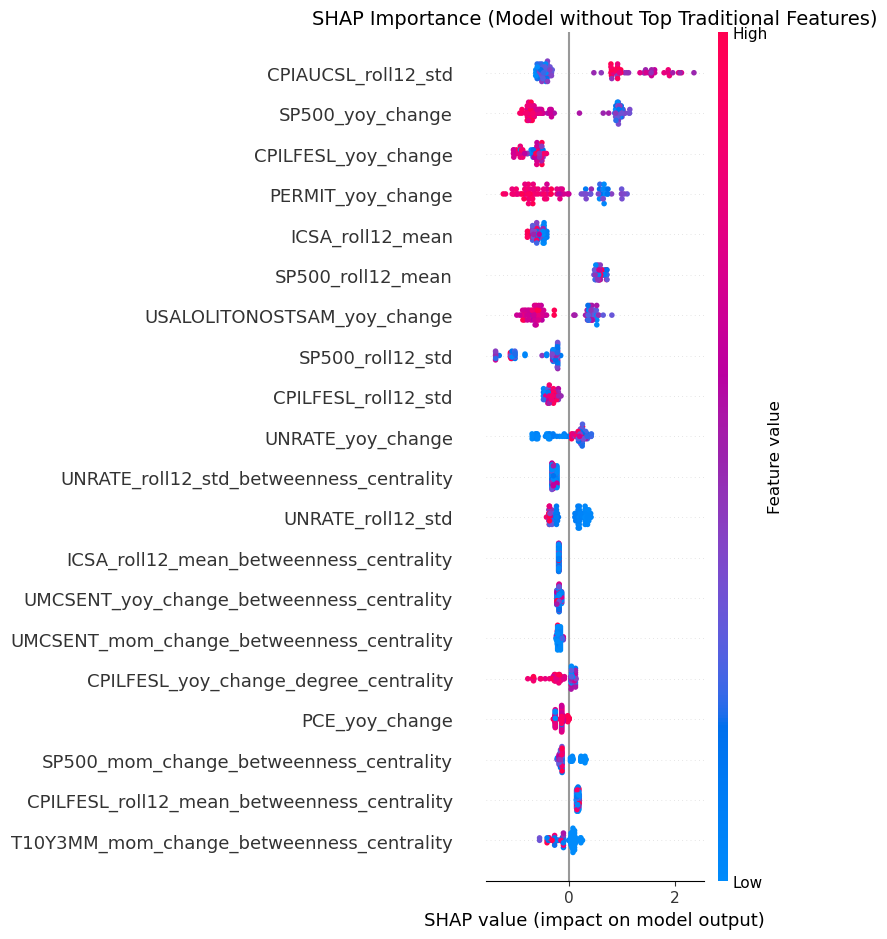

✅ New SHAP summary plot saved to: E:/Project_3/Recession_Prediction_Network_Analysis/visualizations/shap_summary_plot_REDUCED.png


In [5]:
# --- Step 4.4: Re-train and Re-analyze Model on Reduced Features ---
print("\nStep 4.4: Re-training and running SHAP on the reduced-feature model.")

# Re-train XGBoost Model on Reduced Features
model_xgb_reduced = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_xgb_reduced.fit(X_train_scaled_red, y_train_red)
print("✅ New model trained on reduced features.")

# Run SHAP Analysis on the NEW Model
explainer_reduced = shap.TreeExplainer(model_xgb_reduced)
X_val_sample_red = shap.sample(X_val_scaled_red, 100)

print("⏳ Calculating SHAP values for the new model...")
shap_values_reduced = explainer_reduced(X_val_sample_red)
print("✅ SHAP values calculated.")

# Generate and Save the NEW SHAP Plot
print("\n📊 Generating NEW SHAP Summary Plot...")
plt.figure()
plt.title("SHAP Importance (Model without Top Traditional Features)", fontsize=14)
shap.summary_plot(shap_values_reduced, X_val_sample_red, show=False)
plt.tight_layout()
new_summary_plot_path = os.path.join(VISUALIZATIONS_DIR, 'shap_summary_plot_REDUCED.png')
plt.savefig(new_summary_plot_path, dpi=300)
plt.show()
print(f"✅ New SHAP summary plot saved to: {new_summary_plot_path}")

### Phase 4: Interpretation Summary and Final Conclusion

#### **Analysis of SHAP Results:**
* **Full Model Interpretation**: The first SHAP analysis (on the full model) revealed that the model's predictions were overwhelmingly driven by powerful, well-known traditional economic indicators like the OECD Leading Indicator (`USALOLITONOSTSAM`), the yield curve (`T10Y3MM`), and inflation (`CPIAUCSL`). Notably, none of the engineered network centrality features ranked as top predictors.

* **Experimental Model Interpretation**: The second SHAP analysis (on the model retrained without the top traditional features) provided the definitive result. Even when deprived of its strongest predictors, the model still found more predictive power in other traditional metrics (such as S&P 500 volatility and housing permit data) than in the network centrality features.

---
#### **Final Project Conclusion:**

This project successfully demonstrated that augmenting a dataset with network centrality features can improve the performance of a non-linear model like XGBoost for recession prediction, increasing the validation ROC AUC to **0.95**.

However, a deep interpretation using SHAP reveals a more nuanced story. The model's predictive power is still dominated by traditional macroeconomic indicators. The network features, while contributing to a marginal performance lift, appear to capture information that is largely redundant or less powerful than that contained in standard time-series transformations of the base indicators.

The final conclusion is that while network analysis provides a measurable improvement, the primary drivers for this specific recession prediction task remain the powerful, well-established macroeconomic variables.